In [ ]:
# Install PyPortfolioOpt package
# Not a python command (Colab)
!pip install git+https://github.com/multidis/PyPortfolioOpt@master

  Cloning https://github.com/multidis/PyPortfolioOpt (to revision master) to /tmp/pip-req-build-sbeadz_6
  Running command git clone --filter=blob:none --quiet https://github.com/multidis/PyPortfolioOpt /tmp/pip-req-build-sbeadz_6
  Resolved https://github.com/multidis/PyPortfolioOpt to commit 9b79ec95bca88b6a61ddb5a0a9a6de91dbd4b079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyportfolioopt: filename=pyportfolioopt-1.5.5-py3-none-any.whl size=61906 sha256=94d2208e172905591fc95758bf728b256a72eff8532cd326f160b881c6dacf75
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8a597rx/wheels/12/7f/2b/c3c745df1f4476eaff477095ce491934044a9e3c81d225c634
Successfully built pyportfolioopt


In [ ]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import HRPOpt
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# assets for portfolio optimization: select tickers here
tickers = ["QQQ", "IWM", "IYR"]

In [ ]:
# historical data for portfolio selection
fcsv = "https://raw.githubusercontent.com/multidis/hult-ai-investment-management/main/portfolio/etf_assets.csv"
df = pd.read_csv(fcsv, index_col=[0], parse_dates=['Date'])[tickers]
df

,QQQ,IWM,IYR
Date,,,
2012-01-03,51.205013,63.887535,38.757633
2012-01-04,51.420990,63.538139,38.323669
2012-01-05,51.843948,63.896049,38.601681
2012-01-06,52.023937,63.734150,38.533871
2012-01-09,51.852947,64.057976,38.425373
...,...,...,...
2021-12-27,399.909180,219.504959,110.078636
2021-12-28,398.055664,218.163162,110.454269
2021-12-29,397.996216,218.398239,111.176636


In [ ]:
# testing time period data
fcsv = "https://raw.githubusercontent.com/multidis/hult-ai-investment-management/main/portfolio/etf_assets_test.csv"
df_test = pd.read_csv(fcsv, index_col=[0], parse_dates=['Date'])[tickers]
df_test

,QQQ,IWM,IYR
Date,,,
2022-01-03,398.125061,220.680267,111.012886
2022-01-04,392.961182,220.347229,110.801003
2022-01-05,380.889008,212.884155,107.516655
2022-01-06,380.621368,214.098633,107.497391
2022-01-07,376.498169,211.620712,106.775024
...,...,...,...
2022-12-23,266.946716,173.269043,83.656441
2022-12-27,263.172577,172.106567,83.597061
2022-12-28,259.697968,169.433868,82.181847


In [ ]:
# daily returns
df_returns = df.pct_change().dropna()
df_returns_test = df_test.pct_change().dropna()

In [ ]:
# average historical returns
mu = expected_returns.mean_historical_return(df)
mu

QQQ    0.226862
IWM    0.130740
IYR    0.112001
dtype: float64

In [ ]:
# historical covariance matrix
S = risk_models.sample_cov(df)
S

,QQQ,IWM,IYR
QQQ,0.036476,0.030120,0.021122
IWM,0.030120,0.041840,0.026289
IYR,0.021122,0.026289,0.033668


In [ ]:
# find efficient frontier
ef = EfficientFrontier(mu, S)

In [ ]:
# save object copies for further calculations and plotting (auxiliary step)
ef_cp = ef.deepcopy()
ef_tangent = ef.deepcopy()

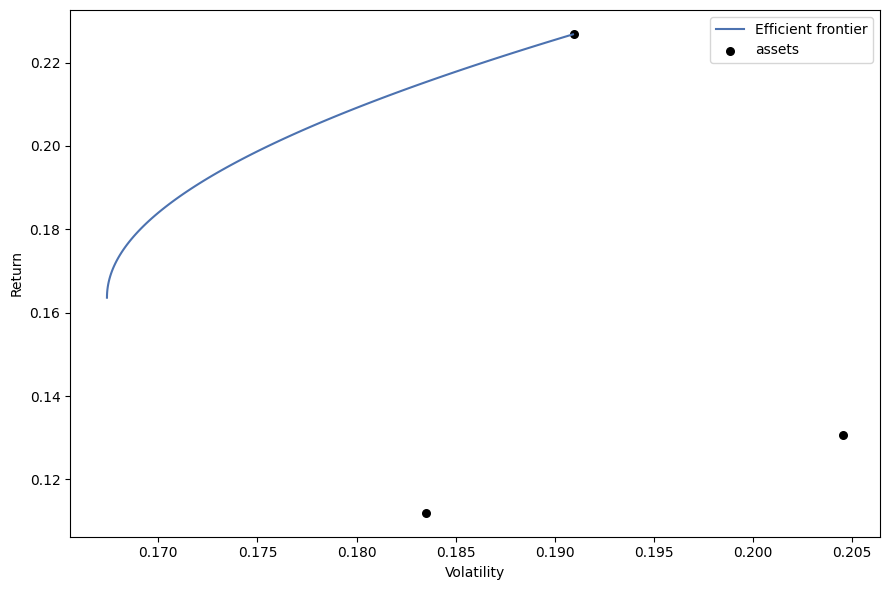

In [ ]:
# plot efficient frontier: see PyPortfolioOpt docs
# https://pyportfolioopt.readthedocs.io/en/latest/Plotting.html
fig, ax = plt.subplots(figsize=(9,6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [ ]:
# find the tangency (max. Sharpe ratio) portfolio
ef_tangent.max_sharpe()
ret_tangent, std_tangent, _ = ef_tangent.portfolio_performance(verbose=True)

Expected annual return: 22.7%
Annual volatility: 19.1%
Sharpe Ratio: 1.08


In [ ]:
# tangency portfolio weights
tangent_weights = ef_tangent.clean_weights()
tangent_weights

OrderedDict([('QQQ', 1.0), ('IWM', 0.0), ('IYR', 0.0)])

In [ ]:
# generate random portfolios for visualization
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
sharpes

array([0.89487524, 0.95389052, 0.73817322, ..., 0.85165801, 0.86175327,
       0.87649833])

In [ ]:
# Hierarchical Risk Parity (HRP) portfolio
hrp = HRPOpt(df_returns)
hrp_weights = hrp.optimize()
hrp_weights

OrderedDict([('IWM', 0.23011555701589817),
             ('IYR', 0.5059274281182667),
             ('QQQ', 0.26395701486583506)])

In [ ]:
ret_hrp, std_hrp, _ = hrp.portfolio_performance(verbose=True)

Expected annual return: 15.4%
Annual volatility: 17.0%
Sharpe Ratio: 0.79


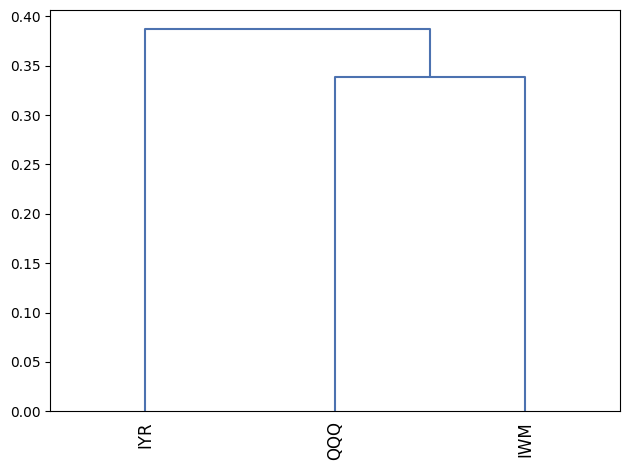

<Axes: >

In [ ]:
# Hierarchical Clustering dendrogram
plotting.plot_dendrogram(hrp, showfig = True)

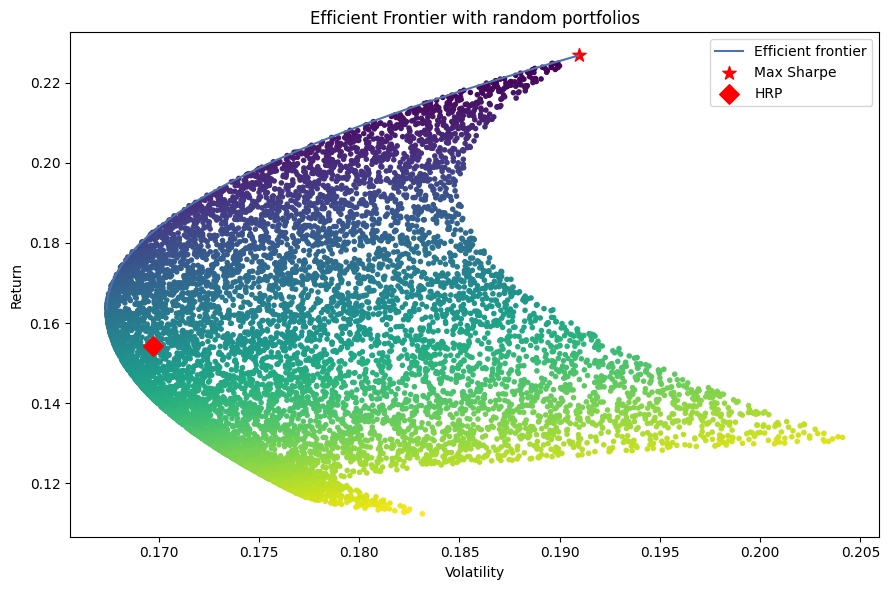

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
plotting.plot_efficient_frontier(ef_cp, ax=ax, show_assets=False)

ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ax.scatter(std_hrp, ret_hrp, marker="D", s=100, c="r", label="HRP")

ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# construct portfolio returns: testing time period
df_returns_test['port_tangent'] = 0
for ticker, weight in tangent_weights.items():
    df_returns_test['port_tangent'] += df_returns_test[ticker]*weight

In [ ]:
df_returns_test['port_hrp'] = 0
for ticker, weight in hrp_weights.items():
    df_returns_test['port_hrp'] += df_returns_test[ticker]*weight

In [ ]:
# cumulative equity curve (recall from the financial data practice earlier)
port_equity_tangent = (1 + df_returns_test['port_tangent']).cumprod() - 1
port_equity_hrp = (1 + df_returns_test['port_hrp']).cumprod() - 1
port_equity = port_equity_tangent.to_frame().join(port_equity_hrp)
port_equity

,port_tangent,port_hrp
Date,,
2022-01-04,-0.012970,-0.004737
2022-01-05,-0.043293,-0.035490
2022-01-06,-0.043965,-0.034490
2022-01-07,-0.054322,-0.043105
2022-01-10,-0.053699,-0.046148
...,...,...
2022-12-23,-0.329490,-0.258450
2022-12-27,-0.338970,-0.262628
2022-12-28,-0.347698,-0.274148


<Axes: xlabel='Date'>

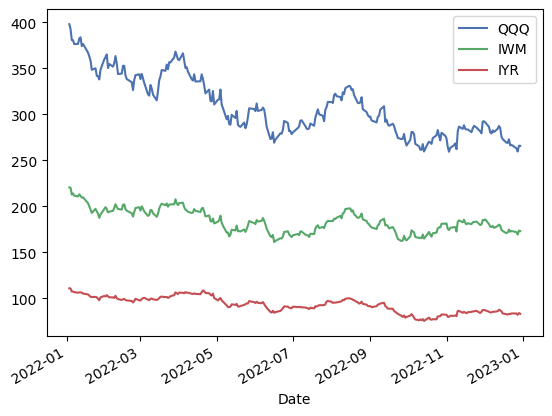

In [ ]:
df_test.plot()

<Axes: xlabel='Date'>

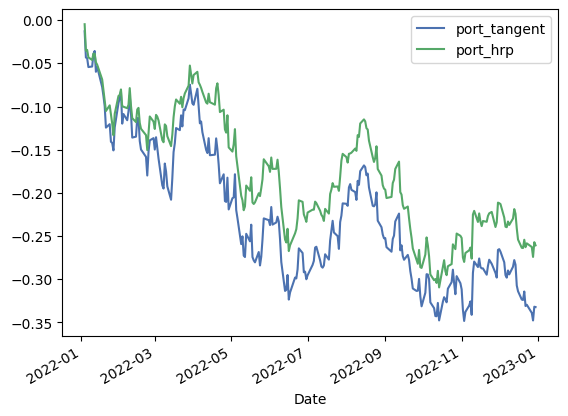

In [ ]:
# out-of-sample performance
port_equity.plot()

In [ ]:
# out-of-sample volatilities
port_equity.std()

port_tangent    0.081691
port_hrp        0.070635
dtype: float64